#Defining modules/packages to import

In [ ]:
import pandas as pd
import re
import nltk
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy


# importing package to recognize stop words i.e. the, and, an etc
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = spacy.lang.en.stop_words.STOP_WORDS

import datetime

import plotly.express as px


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# importing module to ignore the warnings
import warnings
warnings.simplefilter('ignore')


In [ ]:
#connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


#Defining functions to be used¶

In [ ]:
#### Now creating some functions to do text processing
# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """ 
    tweets cleaning by 
    1) lowering the case of the tweet, 
    2) removing unwanted symbols and replacing them with a whitespace, 
    3) split sentences into words according to whitespaces and then 
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string): 
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string (i.e. tweet in this case) and remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')
    pl.show('png')

Search terms used to do tweet scraping¶

In [ ]:
search_terms = ["extinction rebellion", "Greta Thunberg", "climate", "global warming"]

#Now importing database to do analysis


In [ ]:
# importing scraped database and putting it in df, taking only the columns below

#directory to google drive file
DIR = "drive/My Drive/Colab Notebooks"

df1516_dir = '{}{}'.format(DIR, '/env_df1516.csv')
df1516 = pd.read_csv(df1516_dir)[['date','tweet']]
df1516.head()


,date,tweet
0,2016-09-27,I'm fucking dying from global warming.
1,2016-09-27,@DubyaJay2 Some scientists are plausable and s...
2,2016-09-27,Did Trump call global warming a Chinese hoax? ...
3,2016-09-27,@aetaylor55 @NessaAdelaide if we don’t learn n...
4,2016-09-27,@zingaliJR @stevie_sel if you think whether or...


In [ ]:

# taking the 'date' column (which is a string) and extracting date, times, breaking it down in months, years etc

df1516['INCDTTM'] =  pd.to_datetime(df1516['date']) #, infer_datetime_format=True)

df1516['Date'] = [datetime.datetime.date(d) for d in df1516['INCDTTM']]
df1516['Year'] = [datetime.datetime.date(d).year for d in df1516['INCDTTM']] 
df1516['Month'] = [datetime.datetime.date(d).month for d in df1516['INCDTTM']] 
df1516['Day'] = [datetime.datetime.date(d).day for d in df1516['INCDTTM']] 


In [ ]:
df1516 = df1516.drop(columns = ['date','INCDTTM'])

df1516.head()

,tweet,Date,Year,Month,Day
0,I'm fucking dying from global warming.,2016-09-27,2016,9,27
1,@DubyaJay2 Some scientists are plausable and s...,2016-09-27,2016,9,27
2,Did Trump call global warming a Chinese hoax? ...,2016-09-27,2016,9,27
3,@aetaylor55 @NessaAdelaide if we don’t learn n...,2016-09-27,2016,9,27
4,@zingaliJR @stevie_sel if you think whether or...,2016-09-27,2016,9,27


In [ ]:
# removing useless content (hashtags, mentions)
df1516['tweet']=df1516['tweet'].apply(lambda x: remove_content(x))

In [ ]:
# Several functions applied here: processing the *tweet* to remove punctuation, hashtags, mentions
# then removing the search terms used to do the tweets scraping and re-process the *text* 

df1516['cleaned_tweets']=df1516['tweet'].apply(lambda x: process_tweet(x))

#this next row drops from the scraped tweets the same keywords that were used to perform the search.
#if these words are excluded, the sentiment analysis performed with text blob looks at the whole tweet 
#and can spit out a different sentiment wrt if leaving the search terms in. Perhaps worth test it out a bit
#and look at TextBlob with naivebayes too.

#df['cleaned_tweets']=df['cleaned_tweets'].apply(lambda x: remove_search(x, search_concat_unique))

df1516['cleaned_tweets']=df1516['cleaned_tweets'].apply(lambda x: process_text(x))

In [ ]:
df1516.head()

,tweet,Date,Year,Month,Day,cleaned_tweets
0,I'm fucking dying from global warming.,2016-09-27,2016,9,27,fucking dying global warming
1,Some scientists are plausable and some not. G...,2016-09-27,2016,9,27,scientist plausable global warming science fic...
2,Did Trump call global warming a Chinese hoax? ...,2016-09-27,2016,9,27,trump global warming chinese hoax yes tonight ...
3,if we don’t learn now the Chinese will beat ...,2016-09-27,2016,9,27,don learn chinese beat recall invented global ...
4,if you think whether or not he believes in g...,2016-09-27,2016,9,27,think belief global warming worse email scanda...


In [ ]:
# taking the cleaning tweets and dividing them using the space - cleaned tweets contain tweets that are stemmed and cleaned
tweet_list = df1516['cleaned_tweets'].tolist()
all_words=' '.join(tweet_list).split()


In [ ]:
plot_topn(tweet_list, ngram_range=(1,1))


Wordcloud of most used words¶


In [ ]:
from wordcloud import WordCloud, STOPWORDS
temp=' '.join(df1516['cleaned_tweets'].tolist())
wordcloud = WordCloud(width = 800, height = 500, 
                background_color ='white',
                min_font_size = 10).generate(temp)

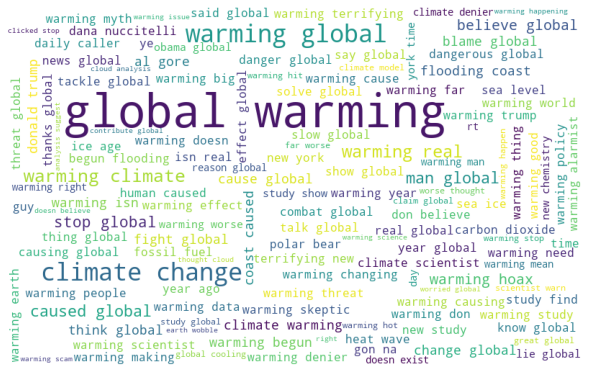

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.tight_layout(pad = 0) 
  
plt.show('png')

Sentiment analysis¶


In [ ]:
from textblob import TextBlob 

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        # set sentiment 
        if analysis.sentiment.polarity > 0: 
            return 'positive'
        elif analysis.sentiment.polarity == 0: 
            return 'neutral'
        else: 
            return 'negative'

In [ ]:
df1516.head()

,tweet,Date,Year,Month,Day,cleaned_tweets
0,I'm fucking dying from global warming.,2016-09-27,2016,9,27,fucking dying global warming
1,Some scientists are plausable and some not. G...,2016-09-27,2016,9,27,scientist plausable global warming science fic...
2,Did Trump call global warming a Chinese hoax? ...,2016-09-27,2016,9,27,trump global warming chinese hoax yes tonight ...
3,if we don’t learn now the Chinese will beat ...,2016-09-27,2016,9,27,don learn chinese beat recall invented global ...
4,if you think whether or not he believes in g...,2016-09-27,2016,9,27,think belief global warming worse email scanda...


In [ ]:
df1516['sentiment']=df1516['cleaned_tweets'].apply(lambda x: get_tweet_sentiment(x))

In [ ]:
df1516.head()

,tweet,Date,Year,Month,Day,cleaned_tweets,sentiment
0,I'm fucking dying from global warming.,2016-09-27,2016,9,27,fucking dying global warming,negative
1,Some scientists are plausable and some not. G...,2016-09-27,2016,9,27,scientist plausable global warming science fic...,neutral
2,Did Trump call global warming a Chinese hoax? ...,2016-09-27,2016,9,27,trump global warming chinese hoax yes tonight ...,neutral
3,if we don’t learn now the Chinese will beat ...,2016-09-27,2016,9,27,don learn chinese beat recall invented global ...,neutral
4,if you think whether or not he believes in g...,2016-09-27,2016,9,27,think belief global warming worse email scanda...,negative


In [ ]:
df1516.sentiment.value_counts()


neutral     268479
positive    130612
negative     94582
Name: sentiment, dtype: int64

In [ ]:
df1516['Positive']= df1516['sentiment'].apply(lambda x: 1 if (x=="positive")  else 0)
df1516['Negative']= df1516['sentiment'].apply(lambda x: 1 if (x=="negative")  else 0)
df1516['Neutral']= df1516['sentiment'].apply(lambda x: 1 if (x=="neutral")  else 0)

df1516.head()

,tweet,Date,Year,Month,Day,cleaned_tweets,sentiment,Positive,Negative,Neutral
0,I'm fucking dying from global warming.,2016-09-27,2016,9,27,fucking dying global warming,negative,0,1,0
1,Some scientists are plausable and some not. G...,2016-09-27,2016,9,27,scientist plausable global warming science fic...,neutral,0,0,1
2,Did Trump call global warming a Chinese hoax? ...,2016-09-27,2016,9,27,trump global warming chinese hoax yes tonight ...,neutral,0,0,1
3,if we don’t learn now the Chinese will beat ...,2016-09-27,2016,9,27,don learn chinese beat recall invented global ...,neutral,0,0,1
4,if you think whether or not he believes in g...,2016-09-27,2016,9,27,think belief global warming worse email scanda...,negative,0,1,0


In [ ]:

df1516_timeline = df1516.groupby(df1516.Date).sum().reset_index()
df1516_timeline['Total'] = df1516_timeline.Positive + df1516_timeline.Negative + df1516_timeline.Neutral
df1516_timeline

,Date,Year,Month,Day,Positive,Negative,Neutral,Total
0,2016-01-23,3320352,1647,37881,373,284,990,1647
1,2016-01-24,5816160,2885,69240,872,521,1492,2885
2,2016-01-25,5796000,2875,71875,850,535,1490,2875
3,2016-01-26,5683104,2819,73294,677,439,1703,2819
4,2016-01-27,4193280,2080,56160,509,341,1230,2080
...,...,...,...,...,...,...,...,...
244,2016-09-23,3090528,13797,35259,407,338,788,1533
245,2016-09-24,2475648,11052,29472,308,294,626,1228
246,2016-09-25,2832480,12645,35125,385,273,747,1405
247,2016-09-26,4783968,21357,61698,784,319,1270,2373


In [ ]:
import numpy as np
from datetime import datetime, timedelta

t = np.arange(df1516_timeline.Date[0], df1516_timeline.Date[248], timedelta(days=7)).astype(datetime)

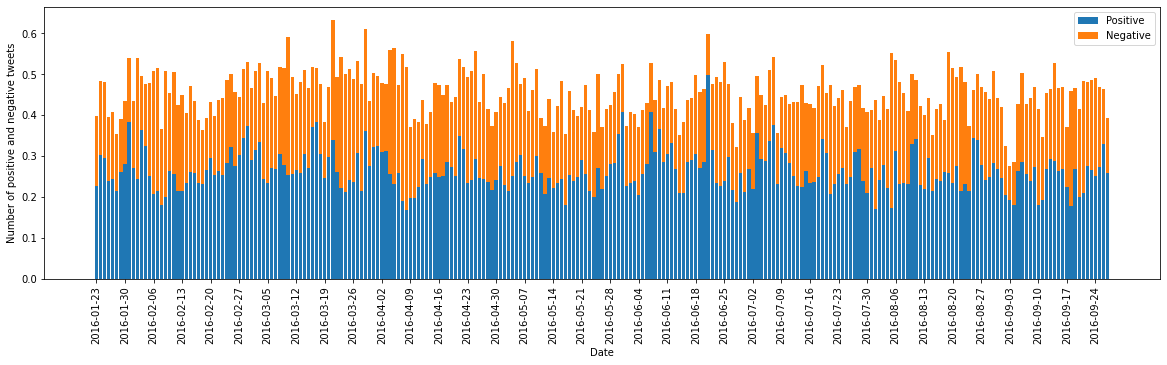

In [ ]:

plt.figure(figsize=(20,5))
plt.bar(df1516_timeline.Date, (df1516_timeline['Positive']/df1516_timeline['Total']));
plt.bar(df1516_timeline.Date, (df1516_timeline['Negative']/df1516_timeline['Total']), bottom = (df1516_timeline['Positive']/df1516_timeline['Total']));
plt.legend(['Positive', 'Negative']);
plt.xticks(t, rotation='vertical');
plt.ylabel('Number of positive and negative tweets');
plt.xlabel('Date');

In [ ]:

import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_bar(x=df1516_timeline.Date, y=df1516_timeline.Negative/(df1516_timeline.Total), name="% Negative")
fig.add_bar(x=df1516_timeline.Date, y=df1516_timeline.Positive/(df1516_timeline.Total), name="% Positive")
#fig.add_bar(x=df_timeline.Date, y=df_timeline.Neutral/df_timeline.Total, name="% Neutral")
fig.add_trace(go.Scatter(x=[df1516_timeline.Date[0], df1516_timeline.Date[248]],y=[0.5,0.5],name="50% threshold"))
fig.update_layout(barmode="relative", showlegend=True, title="Environmental Aspect <br> % Pos & Neg tweets over 1 year period from Oct 2015 to Oct 2016")
fig.show()